# Считывание данных

Преобработанные результаты исследования хранятся в файле `data.csv`. Преобразуем его в датафрейм.

In [1]:
%matplotlib inline

# встроенные
import json
import os.path
import pickle       # хранение токенов
import collections  # используется для подсчета
import re           # обработка текстовой составляющей

# сторонние
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import pymorphy2    # обработка текстовой составляющей

In [3]:
def get_df():
    df = pd.read_csv("data.csv", index_col='№')
    
    # Пока не рассматриваются переводные записи. Комментарии используются лишь как заметки
    df = df.drop(columns=['Name', 'Translation', 'Translation footnote', 'Комментарий'])
    
    # # Добавим столбец подсчета числа символов, из которых состоит запись.
    df['Число символов'] = df['Воспоминание'].apply(lambda x: len(x))
    return df

In [4]:
df = get_df()
df

,Имя,Воспоминание,Пол,Кол-во,Возраст,Ориентир возраста,Мотив,Лица,Предметы,Цвета,Звуки,"Запахи, вкус",Другие ощущения,Сущности,Пространство,Время дня,Время года,Поведение,Число символов
№,,,,,,,,,,,,,,,,,,,
1,Женя,"Мама поставила меня на стул, лицом к окну, шел...",-,1,4,день рождения,встреча дня рождения,мама,"стул, пижама","красный, белый",голос,-,-,снег,комната,-,зима,пассивное,205
2,-,Мне года полтора. Я беру маленький деревянный ...,-,1,1.5,-,"перенос предмета, наблюдение",-,стульчик,-,-,-,-,"солнечный свет, деревянный, квадрат","коридор, комната",день,-,"активное, пассивное",174
3,Таня,"Оно относится к несчастному возрасту, когда ме...",ж,2,1-3,ясли,"опасность нового места, заимствование предмета","мама, папа",игрушка,-,-,суп,"страх, одиночество",лестница,"ясли, дом",-,-,"пассивное, активное",438
4,Кира,"Помню, как бабушка меня качает, а мама смеется...",ж,1,-,-,"качание, расчесывание волос","бабушка, мама","стол, окно, волосы",седой,смех,-,-,седые длинные волосы,дом,-,-,пассивное,164
5,Настя,"Я лежу в кровати с мамой, позднее утро, выходн...",ж,8,<7,-,"кукла, путь до детсада, травма, приченение тра...","мама, бабушка, злой мальчик, девочка,","кукла, санки, коробка, спица, стеклянный стакан",-,собственный плач,-,"боль, желание иметь брата/сестру, обида, униже...",кровь,"кровать, улица, садик, комната, медицинское уч...","утро, вечер",зима,"активное, пассивное",1254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,Толя,"Теплый стан, меня везут в коляске возле местно...",м,1,2-3,коляска,"быть везомым в коляске, видеть кроны деревьев",-,коляска,-,-,-,"видеть кроны деревьев, быть везомым",-,улица,не ночь,-,пассивное,86
686,Сеня,Дедушка был пчеловодом. Он любил пчёл. Он люби...,ж,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1145
687,Аня,"Я в сидячей коляске. Рядом родители, мы в Чехо...",ж,NaN,<2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,189


Для обзора датасета создадим функции подсчета числа пустых ячеек определенного поля, а также вывода необработанной части датасета в порядке возрастания объема записи.

In [5]:
def col_empty_cells(df, col_name:str):
    """Находит пустые и NoneType ячейки столбца с именем col_name"""
    none_cells = df[col_name][~df[col_name].notna()].index
    empty_cells = df[col_name][df[col_name]==''].index
    ids = sorted(list(set(none_cells) | set(empty_cells)))
    return ids

#! Откорректировать так, чтобы учитывались одиночные пустые ячейки
def percent_line():
    df = get_df()
    """Определяет долю полностью обработанных записей, не содержащие пустых строк во всех полях,
    за исключением графы Комментарий. Выводятся строки, в порядке возрастания объема воспоминания"""
    # отбираем записи, содержащие не более 1 пустой графы - обычно это графа комментарий 
    df_not_ready = df[df.apply(lambda x: x.isnull().sum(), axis='columns') > 0]
    p = 100*(1-len(df_not_ready)/len(df))
    print("Осталось обработать целиком записей: {0}, подготовлено {1:.1f}% датасета.".format(len(df_not_ready), p))
    return df_not_ready.sort_values(by='Число символов').head(10)

In [6]:
percent_line()

Осталось обработать целиком записей: 16, подготовлено 97.7% датасета.


,Имя,Воспоминание,Пол,Кол-во,Возраст,Ориентир возраста,Мотив,Лица,Предметы,Цвета,Звуки,"Запахи, вкус",Другие ощущения,Сущности,Пространство,Время дня,Время года,Поведение,Число символов
№,,,,,,,,,,,,,,,,,,,
678,Ян,Помню как играл Пинк Флойд из магнитофона,м,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42
683,Аня,"Я прыгаю на кровати и пою песни, приходит мама...",ж,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90
681,Оля,"Мы летели на очень старом кукурузнике, пол сам...",ж,NaN,2-2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,135
682,Оля,"Мама, отец и я летели в черном вертолете, зате...",ж,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,184
680,Василиса,"Мне нет года, я лежу в детской кроватке и в ко...",ж,1,<1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,187
687,Аня,"Я в сидячей коляске. Рядом родители, мы в Чехо...",ж,NaN,<2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,189
671,Оля,"Я совсем маленькая (не больше двух лет), укута...",ж,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,212
684,Миша,"Я стою в тускло освещенной прихожей, и какой-т...",м,NaN,3-4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,228
677,Полина,Это было в какой-то из майских дождливых холод...,ж,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,256


# Функции предварительной обработки набора данных

In [7]:
#! поиск дубликатов
print('Число дублирующихся записей в датасете: {}.'.format(len(df[df.duplicated()==True])))

Число дублирующихся записей в датасете: 0.


# Исследование распределений

Полностью заполнена лишь графа, содержащая текст воспоминания. Для указания того, что в тексте воспоминания не имеется дополнительной информации, указывает знак "-" (минус). Для анализа полноты используется функция `minus_or_smth_dstrb`.

In [8]:
def minus_or_smth(col_name: str):
    """Выводит число пустых ячеек, ячеек с символом минус и ячеек, содержащих информацию"""
    empty_cell_ids = col_empty_cells(df, col_name)
    print('Число пустых ячеек: {}.'.format(len(empty_cell_ids)))
    df_essential = df.drop(empty_cell_ids)
    column_essential = df_essential[col_name]
    minus_cell_ids = column_essential[column_essential=='-'] 
    print('Число записей, не содержащих информации про {}: {}.'.format(col_name.lower(), len(minus_cell_ids)))
    plus_cell_ids = column_essential[column_essential!='-']
    print('Число записей, содержащих информацию про {}: {}.'.format(col_name.lower(), len(plus_cell_ids)))
    return empty_cell_ids, minus_cell_ids, plus_cell_ids


## Гендерное распределение

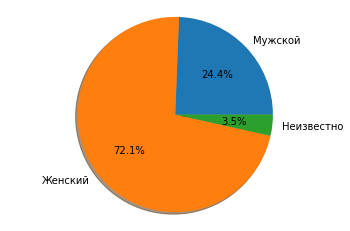

In [9]:
labels = ["Мужской", "Женский", "Неизвестно"]
sizes = [sum(df['Пол']==i) for i in ['м', 'ж', '-']]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
plt.show()

Выборка смещена. Иногда мужчины также отвечали, что не могут ничего вспомнить.

## Распределение возраста

Возраста приводятся в форме приблизительного или точного (при соотнесении с событием) возраста, либо интервала. Интервалы в формате `начало диапазона-конец диапазона` приводим в форму двух чисел. Также имеются описания в которых используются не отрезки, а "лучи" времени (например, "не позже пяти", "после трех лет"). Все виды записей возраста представляются в виде списка словарей с ключами `float`, `range`, `more`, `less`.

In [10]:
#! некорректно обрабатывается строка вида '0.41-0.58; <1'
def age(age_str:'str'):
    '''Возвращает список разбитых на категории возрастов воспоминаний'''
    list_of_ages = []
    
    def age_float(s:'str'):
        list_of_ages.append({'float': float(s)})
    
    def age_range(s:'str'):
        r = [float(item) for item in s.split('-')]
        list_of_ages.append({'range': r})
        
    def age_not_single(s:str):
        if '-' in s:
            age_range(s)
        elif '<' in s:
            list_of_ages.append({'less': float(s[1:])})
        elif '>' in s:
            list_of_ages.append({'more': float(s[1:])})
        else:
            age_float(s)
    
    try:
        age_float(age_str)
    except ValueError:  #!! здесь блоки лучше заменить рекурсией или вызовом функции
        if ';' in age_str:
            for s in age_str.split(';'):
                age_not_single(s)
        else:
            age_not_single(age_str)
    
    return list_of_ages

In [11]:
age_df = df.loc[minus_or_smth('Возраст')[2].index]
age_df['age'] = age_df['Возраст'].apply(lambda x: age(x))

def age_dst_rough(age_list:list):
    '''Метод грубого разбиения возрастов:
    для диапазона используются средние значения интервалов,
    для лучевых отрезков (больше, меньше) - крайние точки'''
    age_rough_list = []
    for d in age_list:
        if 'float' in d:
            age = d['float']
        elif 'range' in d:
            age = sum(d['range'])/2
        elif 'less' in d:
            age = d['less']
        elif 'more' in d:
            age = d['more']
        else:
            age = None
        age_rough_list.append(age)
    return age_rough_list

# грубое разбиение возрастов
age_df['age'].apply(lambda x: age_dst_rough(x))

# минимальный возраст среди нескольких воспоминаний
age_df['min_age'] = age_df['age'].apply(lambda x: min(age_dst_rough(x)))

Число пустых ячеек: 0.
Число записей, не содержащих информации про возраст: 75.
Число записей, содержащих информацию про возраст: 614.


ValueError: could not convert string to float: '1.33,1.25'

KeyError: 'min_age'

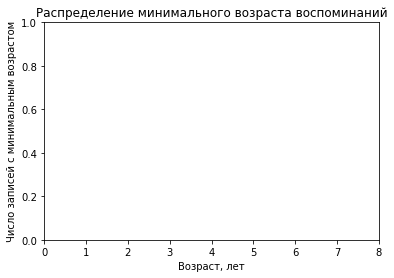

In [12]:
plt.title('Распределение минимального возраста воспоминаний')
plt.xticks(range(0, 9))
plt.xlabel('Возраст, лет')
plt.ylabel('Число записей с минимальным возрастом')
plt.hist(age_df['min_age'], bins=20)
plt.show()

## Уточнение возраста

Во многих случаях возраст не указан, но из самого текста воспоминания можно определить возрастаные границы. Маркерами возраста служат навыки, приобретаемые ребенкам. Для того, чтобы считать эти маркеры, можно использовать столбец «Ориентир возраста», в котором есть такие записи как "неумение ходить", "неумение говорить" и т.п.

Еще одним маркером, позволяющим уточнить возраст является то, что многие воспоминания связаны со встречей дня рождения. Это означает, что ребенку исполняется вполне конкретное число лет. В других случаях мы привыкли называть количество $n$ полных лет, но фактически это означает, что возраст представляет интервал $[n ... n+1)$.

Для "негрубого" построения необходимо найти подходящий тип визуализации, учитывающий "размазанность" интервалов.

# Ориентир возраста

In [ ]:
df = get_df()

In [ ]:
def get_comma_separated_items(column):
    '''Собирает строковые значения, разделенный запятыми в один общий список'''
    item_list = []
    for line in df[column]:
        if line:
            for item in line.split(','):
                item_list.append(item.strip())
    return item_list

In [ ]:
cnt_age_orient = collections.Counter(get_comma_separated_items('Ориентир возраста'))
cnt_age_orient.most_common()

## Мотив

In [ ]:
df = get_df()
cnt_age_orient = collections.Counter(get_comma_separated_items('Мотив'))
cnt_age_orient.most_common()

## Предметы

In [ ]:
def del_category_in_brackets(line:str):
    '''Возвращает название объекта без категории,
    приведенной после названия объекта в скобках'''
    index = line.find(' (')
    if index > 0:
        return line[:index]

# Обработка текстуальной составляющей

[Документация pymorphy2](https://pymorphy2.readthedocs.io/en/latest/user/index.html)

## Распределение числа воспоминаний в записях

## Распределение объема воспоминаний
- по числу воспоминаний в записи
- по числу символов, слов, предложений
- по числу предложений, приходящихся на одно воспоминание

### Распределение числа символов в записях

In [ ]:
get_df()

In [ ]:
plt.xlim(left=0, right=1500)
plt.title('Распределение числа символов в записях')
plt.xlabel('Число символов')
plt.ylabel('Число записей')
plt.hist(df['Число символов'], bins=200)
plt.show()

## Среднее, минимальное и максимальное число символов, приходящееся на одно воспоминание

## Сколько предложений в среднем приходится на одно воспоминание?

In [ ]:
morph = pymorphy2.MorphAnalyzer()
get_df()
one_string = '\n\n'.join(df['Воспоминание'])

In [ ]:
# Найдем список всех слов

s = re.sub(r'[^a-zA-Zа-яА-Я0-9- ]', ' ', one_string)
# список всех слов корпуса текста (с повторами, в порядке появления)
words = s.split()  

In [ ]:
norm_words = []

for word in words:
    p = morph.parse(word)
    norm_words.append(p[0].normalized.word)

Сравним число исходных и нормализованных слов

In [ ]:
l = [len(words), len(set(words)), len(set(norm_words))]
print('Число слов в тексте: {}, с учетом повторов: {}, нормализованных с учетом повторов: {}.'.format(*l))

Посчитаем число слов, найдем самые распространенные, не относящиеся к союзам, предлогам, местоимениям, частицам и междометиям:

In [ ]:
word = 'я'
p = morph.parse(word)
str(p[0].tag.POS)

In [ ]:
import collections

cnt = collections.Counter(norm_words)
not_value_gram = ['NPRO', 'CONJ', 'PREP', 'PRCL', 'INTJ']

# Обнулим счетчик для слов тех частей речи, что относятся к перечисленным
for key in cnt.keys():
    p = morph.parse(key)
    if str(p[0].tag.POS) in not_value_gram:
        cnt[key] = -1
        
print(cnt.most_common(20))

## Проверка на опечатки

С помощью `pymorphy` было бы полезно поискать случаи, когда не находится нормальная форма слова – не опечатка ли это?

## Частотное распределение слов, приведенных к нормальной форме

## Сравнение ситуаций упоминания сущностей "мама, папа" и "родители"

## В каком времени написаны воспоминания? Прошедшем или настоящем? То есть с взглядом из текущего времени или с эмоциональным погружением в ситуацию?

Для этого можно рассмотреть время глаголов воспоминаний. В грубом приближении достаточно ориентироваться на, глаголы какого времени преобладают – настоящего или прошедшего.

# Поиск наиболее близких по содержанию текстов
Сравним тексты воспоминаний по близости друг к другу. Отыщем наиболее близкие пары текстов. Рассмотрим отдельно задачи а) близости записей и б) близости отдельных воспоминаний. 

# Генерация latex для верстки pdf 

Нужно создать инструмент для представления исходных данных и обработанных в верстке удобной для публикации в pdf (LaTeX), в виде статьи на Medium, в fb2, epub-форматах с заголовками и содержанием. Также необходимо инструмент перечисления номеров воспоминаний - замена последовательности на соответствующие ссылки-якоря

# Сохранение результатов
Обработанный набор данных сохранив в виде отдельного датасета.